# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
# !pip3 install torch torchvision

# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0")  # Let's make sure GPU is available!

# Загружаем данные

In [13]:
# First, lets load the dataset
data_train = dset.SVHN('./data',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                                std=[0.20, 0.20, 0.20])
                       ])
                       )
data_test = dset.SVHN('./data', split='test', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43, 0.44, 0.47],
                         std=[0.20, 0.20, 0.20])
]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [15]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=0)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, num_workers=0)
del indices, train_indices, val_indices

In [6]:
from time import time


def dataloader_test(loader, num_epochs):
    start = time()
    for epoch in range(num_epochs):
        start_epoch = time()
        for x, y in loader:
            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
#             pass
        print(f'epoch {epoch} time {time()-start_epoch}')
    print(f'summary time {time()-start}')


dataloader_test(train_loader, 5)

epoch 0 time 13.142887115478516
epoch 1 time 8.960036516189575
epoch 2 time 8.94799518585205
epoch 3 time 8.958033084869385
epoch 4 time 9.095001935958862
summary time 49.105886936187744


In [3]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),
    Flattener(),
    nn.Linear(64*2*2, 10),
)

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [6]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" %
              (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    # model.eval()  # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!

    correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in loader:
            model.eval()
            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
            total_samples += y.shape[0]
            prediction = torch.argmax(model(x_gpu), dim=1)
            correct += torch.sum(prediction == y_gpu)

    return float(correct)/total_samples


In [ ]:
loss_history, train_history, val_history = train_model(
    nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [10]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43, 0.44, 0.47],
                         std=[0.20, 0.20, 0.20])
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data/',
                           transform=tfs
                           )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                               sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

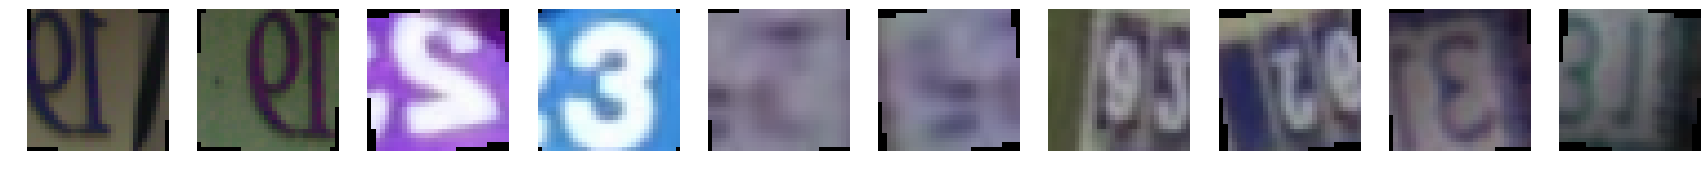

In [11]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./data/',
                         transform=tfs
                         )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [11]:
# TODO:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43, 0.44, 0.47],
                         std=[0.20, 0.20, 0.20])
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data/',
                           transform=tfs
                           )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=4)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, num_workers=0)  # pin_memory=True,

In [13]:
dataloader_test(train_aug_loader, 5)

epoch 0 time 15.888985872268677
epoch 1 time 15.673996448516846
epoch 2 time 15.785985469818115
epoch 3 time 15.747260808944702
epoch 4 time 15.810038566589355
summary time 78.9092493057251


In [14]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(
    nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.593767, Train accuracy: 0.818585, Val accuracy: 0.832162
Average loss: 0.546778, Train accuracy: 0.834471, Val accuracy: 0.838578
Average loss: 0.534573, Train accuracy: 0.838720, Val accuracy: 0.839601
Average loss: 0.510066, Train accuracy: 0.846500, Val accuracy: 0.862467
Average loss: 0.501522, Train accuracy: 0.848719, Val accuracy: 0.853457


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [15]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(16, 120, 5),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    nn.LogSoftmax(dim=-1)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [16]:
# Let's train it!
loss_history, train_history, val_history = train_model(
    lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.627626, Train accuracy: 0.437617, Val accuracy: 0.778991
Average loss: 0.596999, Train accuracy: 0.822544, Val accuracy: 0.856051
Average loss: 0.480291, Train accuracy: 0.855646, Val accuracy: 0.874684
Average loss: 0.429099, Train accuracy: 0.872027, Val accuracy: 0.871818
Average loss: 0.389770, Train accuracy: 0.882452, Val accuracy: 0.879599
Average loss: 0.363545, Train accuracy: 0.890694, Val accuracy: 0.886219
Average loss: 0.344985, Train accuracy: 0.895591, Val accuracy: 0.891885
Average loss: 0.323041, Train accuracy: 0.901665, Val accuracy: 0.877892
Average loss: 0.309723, Train accuracy: 0.907194, Val accuracy: 0.890861
Average loss: 0.300170, Train accuracy: 0.908576, Val accuracy: 0.898710


# Подбор гиперпараметров

In [21]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple(
    "Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple(
    "RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])


In [17]:
# learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
# anneal_coeff = 0.2
# anneal_epochs = [1, 5, 10, 15, 20, 50]
# reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

# Use grid search or random search and record all runs in run_record dictionnary
# Important: perform search in logarithmic space!

# TODO: Your code here!
manualSeed = 42

np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# if you are suing GPU
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)


def _init_fn():
    np.random.seed(manualSeed)


train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=4)#worker_init_fn=_init_fn,
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, num_workers=0)

# learning_rates = list(np.logspace(
#     np.log10(5e-5), np.log10(0.5), base=10, num=10000))
learning_rates = list(5*10**np.linspace(-3,-1,100))
anneal_epochs = [2, 5, 10]
anneal_coeff = 0.2
# reg = list(np.logspace(np.log10(1e-7), np.log10(1e-4), base=10, num=1000))
reg = list(10**np.linspace(-7,-4,1000))

max_evals = 120

for _ in range(max_evals):
    torch.manual_seed(manualSeed)
    # if you are suing GPU
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(16, 120, 5),
        nn.ReLU(inplace=True),
        Flattener(),
        nn.Linear(120, 84),
        nn.ReLU(inplace=True),
        nn.Linear(84, 10),
        nn.LogSoftmax(dim=-1)
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)
    
    lr = np.random.choice(learning_rates,1)[0]
    l2 = np.random.choice(reg,1)[0]
    print(f'Start lr={lr}, l2={l2}')

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adadelta(lenet_model.parameters(), lr=lr, weight_decay=l2)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num)
    h = Hyperparams(lr,None,l2)
    run_record[h] = RunResult(lenet_model,train_history,val_history,val_history[-1])
    print('End')
    

Start lr=0.053613361100516184, l2=3.824569722466999e-05
Average loss: 2.123905, Train accuracy: 0.242381, Val accuracy: 0.457716
Average loss: 1.263296, Train accuracy: 0.602703, Val accuracy: 0.715105
Average loss: 0.895068, Train accuracy: 0.730795, Val accuracy: 0.747799
Average loss: 0.762092, Train accuracy: 0.774750, Val accuracy: 0.795099
Average loss: 0.683060, Train accuracy: 0.799321, Val accuracy: 0.819535
Average loss: 0.634133, Train accuracy: 0.814695, Val accuracy: 0.830046
Average loss: 0.593672, Train accuracy: 0.828328, Val accuracy: 0.842127
Average loss: 0.562474, Train accuracy: 0.837082, Val accuracy: 0.850044
Average loss: 0.535280, Train accuracy: 0.845118, Val accuracy: 0.853730
Average loss: 0.513553, Train accuracy: 0.852063, Val accuracy: 0.860214
End
Start lr=0.009589551308362443, l2=2.081221569986337e-07
Average loss: 2.256694, Train accuracy: 0.175613, Val accuracy: 0.190840
Average loss: 2.235075, Train accuracy: 0.188837, Val accuracy: 0.190840
Average 

Average loss: 2.218182, Train accuracy: 0.189213, Val accuracy: 0.191386
Average loss: 2.194141, Train accuracy: 0.193001, Val accuracy: 0.205447
Average loss: 2.149113, Train accuracy: 0.223697, Val accuracy: 0.238072
Average loss: 2.076260, Train accuracy: 0.270279, Val accuracy: 0.314245
Average loss: 1.977486, Train accuracy: 0.329779, Val accuracy: 0.366118
Average loss: 1.870136, Train accuracy: 0.384312, Val accuracy: 0.414511
End
Start lr=0.01926764296855264, l2=2.614673211801092e-05
Average loss: 2.245991, Train accuracy: 0.182831, Val accuracy: 0.190840
Average loss: 2.179420, Train accuracy: 0.206771, Val accuracy: 0.267695
Average loss: 1.866076, Train accuracy: 0.380354, Val accuracy: 0.455942
Average loss: 1.482138, Train accuracy: 0.529604, Val accuracy: 0.601051
Average loss: 1.202394, Train accuracy: 0.629048, Val accuracy: 0.677838
Average loss: 1.028905, Train accuracy: 0.688206, Val accuracy: 0.714354
Average loss: 0.927280, Train accuracy: 0.723697, Val accuracy: 0

Average loss: 1.158125, Train accuracy: 0.645889, Val accuracy: 0.669784
End
Start lr=0.08536763237353458, l2=1.148312414543511e-05
Average loss: 1.853524, Train accuracy: 0.356841, Val accuracy: 0.666507
Average loss: 0.907282, Train accuracy: 0.725984, Val accuracy: 0.788615
Average loss: 0.701587, Train accuracy: 0.794014, Val accuracy: 0.798512
Average loss: 0.613808, Train accuracy: 0.820991, Val accuracy: 0.841035
Average loss: 0.554884, Train accuracy: 0.838157, Val accuracy: 0.852433
Average loss: 0.518820, Train accuracy: 0.848514, Val accuracy: 0.858030
Average loss: 0.484305, Train accuracy: 0.858189, Val accuracy: 0.865470
Average loss: 0.459154, Train accuracy: 0.864519, Val accuracy: 0.868814
Average loss: 0.438947, Train accuracy: 0.870423, Val accuracy: 0.875367
Average loss: 0.420366, Train accuracy: 0.877385, Val accuracy: 0.875367
End
Start lr=0.08536763237353458, l2=4.871780218794631e-06
Average loss: 1.851176, Train accuracy: 0.358410, Val accuracy: 0.664392
Averag

Average loss: 2.210760, Train accuracy: 0.189776, Val accuracy: 0.193980
Average loss: 2.161041, Train accuracy: 0.214654, Val accuracy: 0.242236
Average loss: 2.059980, Train accuracy: 0.278231, Val accuracy: 0.331513
Average loss: 1.917212, Train accuracy: 0.361977, Val accuracy: 0.398812
Average loss: 1.765888, Train accuracy: 0.427772, Val accuracy: 0.466862
Average loss: 1.616440, Train accuracy: 0.484558, Val accuracy: 0.520579
Average loss: 1.476105, Train accuracy: 0.535065, Val accuracy: 0.562487
End
Start lr=0.05616620164890138, l2=4.939621743878326e-05
Average loss: 2.105175, Train accuracy: 0.250691, Val accuracy: 0.480786
Average loss: 1.221477, Train accuracy: 0.617804, Val accuracy: 0.723432
Average loss: 0.872317, Train accuracy: 0.738542, Val accuracy: 0.753327
Average loss: 0.744462, Train accuracy: 0.781046, Val accuracy: 0.803358
Average loss: 0.667354, Train accuracy: 0.803877, Val accuracy: 0.823289
Average loss: 0.619080, Train accuracy: 0.818278, Val accuracy: 0

Average loss: 1.786403, Train accuracy: 0.419735, Val accuracy: 0.454918
Average loss: 1.653436, Train accuracy: 0.472170, Val accuracy: 0.501126
End
Start lr=0.005748784976988678, l2=2.9205555121827452e-05
Average loss: 2.267153, Train accuracy: 0.166109, Val accuracy: 0.190840
Average loss: 2.240862, Train accuracy: 0.188820, Val accuracy: 0.190840
Average loss: 2.235357, Train accuracy: 0.188803, Val accuracy: 0.190840
Average loss: 2.227195, Train accuracy: 0.188820, Val accuracy: 0.190840
Average loss: 2.209810, Train accuracy: 0.190339, Val accuracy: 0.193366
Average loss: 2.173891, Train accuracy: 0.205644, Val accuracy: 0.231315
Average loss: 2.106982, Train accuracy: 0.248234, Val accuracy: 0.277046
Average loss: 2.007130, Train accuracy: 0.313193, Val accuracy: 0.357040
Average loss: 1.888801, Train accuracy: 0.375849, Val accuracy: 0.411781
Average loss: 1.768654, Train accuracy: 0.428506, Val accuracy: 0.458330
End
Start lr=0.36104045091927334, l2=1.28264983052806e-05
Avera

Average loss: 0.492226, Train accuracy: 0.855151, Val accuracy: 0.858098
Average loss: 0.437255, Train accuracy: 0.871566, Val accuracy: 0.878029
Average loss: 0.399104, Train accuracy: 0.881036, Val accuracy: 0.891680
Average loss: 0.372582, Train accuracy: 0.890813, Val accuracy: 0.891407
Average loss: 0.350094, Train accuracy: 0.897451, Val accuracy: 0.895229
Average loss: 0.335521, Train accuracy: 0.899976, Val accuracy: 0.891611
Average loss: 0.320595, Train accuracy: 0.905180, Val accuracy: 0.899597
Average loss: 0.306375, Train accuracy: 0.909293, Val accuracy: 0.902327
End
Start lr=0.21643806405415297, l2=4.331483223376394e-05
Average loss: 1.291401, Train accuracy: 0.573730, Val accuracy: 0.806157
Average loss: 0.620497, Train accuracy: 0.817664, Val accuracy: 0.852024
Average loss: 0.507235, Train accuracy: 0.849981, Val accuracy: 0.855163
Average loss: 0.449995, Train accuracy: 0.867351, Val accuracy: 0.875162
Average loss: 0.407024, Train accuracy: 0.879893, Val accuracy: 0

Average loss: 1.820502, Train accuracy: 0.407723, Val accuracy: 0.447068
Average loss: 1.674415, Train accuracy: 0.463621, Val accuracy: 0.500444
Average loss: 1.532701, Train accuracy: 0.514316, Val accuracy: 0.545014
End
Start lr=0.08943247645287175, l2=2.5966559729348724e-07
Average loss: 1.828060, Train accuracy: 0.366003, Val accuracy: 0.675108
Average loss: 0.890631, Train accuracy: 0.732604, Val accuracy: 0.791891
Average loss: 0.688328, Train accuracy: 0.797512, Val accuracy: 0.801925
Average loss: 0.603717, Train accuracy: 0.825103, Val accuracy: 0.843151
Average loss: 0.544658, Train accuracy: 0.840682, Val accuracy: 0.854890
Average loss: 0.510651, Train accuracy: 0.850357, Val accuracy: 0.861375
Average loss: 0.477037, Train accuracy: 0.860612, Val accuracy: 0.867245
Average loss: 0.452363, Train accuracy: 0.867061, Val accuracy: 0.870726
Average loss: 0.432701, Train accuracy: 0.872539, Val accuracy: 0.877005
Average loss: 0.414859, Train accuracy: 0.877914, Val accuracy: 

Average loss: 2.222783, Train accuracy: 0.189230, Val accuracy: 0.192888
Average loss: 2.125299, Train accuracy: 0.238184, Val accuracy: 0.303802
Average loss: 1.866454, Train accuracy: 0.384773, Val accuracy: 0.454986
Average loss: 1.573180, Train accuracy: 0.500700, Val accuracy: 0.552863
Average loss: 1.333963, Train accuracy: 0.582858, Val accuracy: 0.623166
Average loss: 1.160507, Train accuracy: 0.647988, Val accuracy: 0.681796
Average loss: 1.038189, Train accuracy: 0.687114, Val accuracy: 0.723159
Average loss: 0.953012, Train accuracy: 0.714637, Val accuracy: 0.737970
Average loss: 0.892924, Train accuracy: 0.735761, Val accuracy: 0.755307
End
Start lr=0.286118382967511, l2=2.5966559729348725e-05
Average loss: 1.163844, Train accuracy: 0.618503, Val accuracy: 0.823425
Average loss: 0.574405, Train accuracy: 0.829847, Val accuracy: 0.859600
Average loss: 0.478091, Train accuracy: 0.857677, Val accuracy: 0.859259
Average loss: 0.426785, Train accuracy: 0.874194, Val accuracy: 0.

Average loss: 1.005744, Train accuracy: 0.698853, Val accuracy: 0.730462
Average loss: 0.918416, Train accuracy: 0.727690, Val accuracy: 0.758310
Average loss: 0.857439, Train accuracy: 0.745794, Val accuracy: 0.765067
Average loss: 0.813628, Train accuracy: 0.762038, Val accuracy: 0.776944
End
Start lr=0.18824679033962347, l2=1.1016459496336569e-07
Average loss: 1.343862, Train accuracy: 0.554141, Val accuracy: 0.797283
Average loss: 0.646207, Train accuracy: 0.810719, Val accuracy: 0.844994
Average loss: 0.528100, Train accuracy: 0.844231, Val accuracy: 0.849498
Average loss: 0.469110, Train accuracy: 0.861175, Val accuracy: 0.866425
Average loss: 0.425137, Train accuracy: 0.874450, Val accuracy: 0.881783
Average loss: 0.399500, Train accuracy: 0.881053, Val accuracy: 0.885332
Average loss: 0.373191, Train accuracy: 0.890728, Val accuracy: 0.888472
Average loss: 0.355293, Train accuracy: 0.895233, Val accuracy: 0.894273
Average loss: 0.339548, Train accuracy: 0.900471, Val accuracy: 

Average loss: 1.566646, Train accuracy: 0.469150, Val accuracy: 0.754761
Average loss: 0.743720, Train accuracy: 0.779084, Val accuracy: 0.821582
Average loss: 0.602459, Train accuracy: 0.823858, Val accuracy: 0.825336
Average loss: 0.532558, Train accuracy: 0.844623, Val accuracy: 0.857416
Average loss: 0.481606, Train accuracy: 0.858120, Val accuracy: 0.868746
Average loss: 0.449933, Train accuracy: 0.868205, Val accuracy: 0.873592
Average loss: 0.422200, Train accuracy: 0.876190, Val accuracy: 0.876459
Average loss: 0.400106, Train accuracy: 0.882094, Val accuracy: 0.882738
Average loss: 0.382664, Train accuracy: 0.887213, Val accuracy: 0.886015
Average loss: 0.368477, Train accuracy: 0.891120, Val accuracy: 0.887994
End
Start lr=0.26070041439998437, l2=2.43998629725955e-05
Average loss: 1.215733, Train accuracy: 0.600706, Val accuracy: 0.817692
Average loss: 0.590443, Train accuracy: 0.825189, Val accuracy: 0.857689
Average loss: 0.487860, Train accuracy: 0.856346, Val accuracy: 0.

Average loss: 0.519011, Train accuracy: 0.849077, Val accuracy: 0.857006
Average loss: 0.484004, Train accuracy: 0.858223, Val accuracy: 0.865879
Average loss: 0.459457, Train accuracy: 0.865475, Val accuracy: 0.869224
Average loss: 0.438837, Train accuracy: 0.870832, Val accuracy: 0.875094
Average loss: 0.421196, Train accuracy: 0.877077, Val accuracy: 0.876664
End
Start lr=0.005, l2=1.3462605792989111e-06
Average loss: 2.270792, Train accuracy: 0.162253, Val accuracy: 0.190840
Average loss: 2.241947, Train accuracy: 0.188820, Val accuracy: 0.190840
Average loss: 2.237290, Train accuracy: 0.188803, Val accuracy: 0.190840
Average loss: 2.231557, Train accuracy: 0.188803, Val accuracy: 0.190840
Average loss: 2.221354, Train accuracy: 0.188974, Val accuracy: 0.191181
Average loss: 2.201503, Train accuracy: 0.190663, Val accuracy: 0.197188
Average loss: 2.164858, Train accuracy: 0.211804, Val accuracy: 0.221623
Average loss: 2.104211, Train accuracy: 0.251152, Val accuracy: 0.294860
Avera

Average loss: 2.244376, Train accuracy: 0.183377, Val accuracy: 0.190840
Average loss: 2.149443, Train accuracy: 0.223015, Val accuracy: 0.321343
Average loss: 1.762608, Train accuracy: 0.425963, Val accuracy: 0.501058
Average loss: 1.372166, Train accuracy: 0.568969, Val accuracy: 0.638523
Average loss: 1.113502, Train accuracy: 0.659898, Val accuracy: 0.705071
Average loss: 0.963634, Train accuracy: 0.710217, Val accuracy: 0.734148
Average loss: 0.876452, Train accuracy: 0.741886, Val accuracy: 0.765340
Average loss: 0.814460, Train accuracy: 0.761748, Val accuracy: 0.785339
Average loss: 0.769466, Train accuracy: 0.773982, Val accuracy: 0.790185
Average loss: 0.736596, Train accuracy: 0.785739, Val accuracy: 0.797352
End
Start lr=0.286118382967511, l2=4.973895958790068e-07
Average loss: 1.157802, Train accuracy: 0.621216, Val accuracy: 0.824790
Average loss: 0.569383, Train accuracy: 0.832338, Val accuracy: 0.857484
Average loss: 0.476061, Train accuracy: 0.858376, Val accuracy: 0.8

In [22]:
try:
    with open('data/hp_none.pkl','rb') as f:
        run_record=pickle.load(f)
except FileNotFoundError:
    with open('data/hp_none.pkl','wb') as f:
        pickle.dump(run_record,f)

In [28]:
best_hyperparams = None
best_val_accuracy = None
epoch_num = 50

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        
for ae in anneal_epochs:
    torch.manual_seed(manualSeed)
    # if you are suing GPU
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(16, 120, 5),
        nn.ReLU(inplace=True),
        Flattener(),
        nn.Linear(120, 84),
        nn.ReLU(inplace=True),
        nn.Linear(84, 10),
        nn.LogSoftmax(dim=-1)
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)
    
    lr = best_hyperparams.learning_rate
    l2 = best_hyperparams.reg
    
    train_history, val_history = [], []
    print(f'Start ae = {ae}')

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adadelta(lenet_model.parameters(), lr=lr, weight_decay=l2)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=anneal_coeff)
    for i in range(0,epoch_num,ae):
        loss_history_, train_history_, val_history_ = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, ae)
        scheduler.step()
        train_history.extend(train_history_)
        val_history.extend(val_history_)
    h = Hyperparams(lr,ae,l2)
    run_record[h] = RunResult(lenet_model,train_history,val_history,val_history[-1])
    print('End')
        

Start ae = 2
Average loss: 1.224312, Train accuracy: 0.597072, Val accuracy: 0.815166
Average loss: 0.598756, Train accuracy: 0.822919, Val accuracy: 0.856733
Average loss: 0.479203, Train accuracy: 0.859212, Val accuracy: 0.866494
Average loss: 0.459362, Train accuracy: 0.865099, Val accuracy: 0.871203
Average loss: 0.436004, Train accuracy: 0.872351, Val accuracy: 0.873592
Average loss: 0.436351, Train accuracy: 0.872624, Val accuracy: 0.875299
Average loss: 0.429761, Train accuracy: 0.874347, Val accuracy: 0.875845
Average loss: 0.428272, Train accuracy: 0.874296, Val accuracy: 0.876049
Average loss: 0.427345, Train accuracy: 0.875781, Val accuracy: 0.876118
Average loss: 0.427316, Train accuracy: 0.875781, Val accuracy: 0.875913
Average loss: 0.425507, Train accuracy: 0.875235, Val accuracy: 0.875981
Average loss: 0.426691, Train accuracy: 0.874774, Val accuracy: 0.875981
Average loss: 0.426984, Train accuracy: 0.874740, Val accuracy: 0.875981
Average loss: 0.427028, Train accuracy

Average loss: 0.256022, Train accuracy: 0.926014, Val accuracy: 0.907720
Average loss: 0.251279, Train accuracy: 0.927448, Val accuracy: 0.906901
Average loss: 0.247284, Train accuracy: 0.928540, Val accuracy: 0.908334
Average loss: 0.245460, Train accuracy: 0.929888, Val accuracy: 0.908334
Average loss: 0.242247, Train accuracy: 0.930570, Val accuracy: 0.908743
Average loss: 0.239667, Train accuracy: 0.930826, Val accuracy: 0.907583
Average loss: 0.237716, Train accuracy: 0.931440, Val accuracy: 0.907310
Average loss: 0.235697, Train accuracy: 0.932993, Val accuracy: 0.907447
Average loss: 0.226142, Train accuracy: 0.935331, Val accuracy: 0.909767
Average loss: 0.223385, Train accuracy: 0.936884, Val accuracy: 0.909631
Average loss: 0.223205, Train accuracy: 0.936065, Val accuracy: 0.910177
Average loss: 0.220891, Train accuracy: 0.936372, Val accuracy: 0.909767
Average loss: 0.221850, Train accuracy: 0.937703, Val accuracy: 0.910177
Average loss: 0.220716, Train accuracy: 0.937310, V

In [23]:
try:
    with open('data/hp.pkl','rb') as f:
        run_record=pickle.load(f)
except FileNotFoundError:
    with open('data/hp.pkl','wb') as f:
        pickle.dump(run_record,f)

In [28]:
best_val_accuracy = None
best_hyperparams = None
best_run = None
best_model = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        best_model = run_result.model

print("Best validation accuracy: %4.2f, best hyperparams: %s" %
      (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=0.24885117821660557, anneal_epochs=10, reg=1.4426439512181588e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [10]:
class CV_Model(object):
    def __init__(self, nn_model, tfs=None, batch_size=64, learning_rate=1e-1, reg=1e-5, anneal_coeff=0.1, num_epochs=10,
                 model_status=None, validation_split=0.2, num_workers=0, random_state=None):
        self.model = nn_model
        self.transforms = tfs
        self.batch_size = batch_size
        self.lr = learning_rate
        self.reg = reg
        self.anneal_coeff = anneal_coeff
        self.num_epochs = num_epochs

        if model_status:
            self.model.load_state_dict(torch.load(model_status))
        self.vs = validation_split
        self.num_workers = num_workers
        if random_state:
            self.random_state = random_state
            np.random.seed(random_state)
            random.seed(random_state)
            torch.manual_seed(random_state)
            # if you are suing GPU
            torch.cuda.manual_seed(random_state)
            torch.cuda.manual_seed_all(random_state)

    def _init_fn(self):
        np.random.seed(self.random_state)

    def fit(self):
        # Load data
        data_train = dset.SVHN('./data',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                                std=[0.20, 0.20, 0.20])
                       ])
                       )
        data_size = data_train.data.shape[0]
        split = int(np.floor(self.vs * data_size))
        indices = list(range(data_size))
        np.random.shuffle(indices)

        train_indices, val_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        data_aug_train = dset.SVHN('./data/',
                           transform=self.transforms
                           )
        train_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=self.batch_size,
                                                       # worker_init_fn=self._init_fn,
                                                       sampler=train_sampler, num_workers=self.num_workers)
        val_loader = torch.utils.data.DataLoader(data_train, batch_size=self.batch_size,
                                                 # worker_init_fn=self._init_fn,
                                                 sampler=val_sampler, num_workers=0)
        # model params
        self.model.type(torch.cuda.FloatTensor)
        self.model.to(device)
        loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
        optimizer = optim.Adadelta(self.model.parameters(), lr=self.lr, weight_decay=self.reg)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                         factor=self.anneal_coeff, patience=2,
#                                                          threshold=1e-3, eps=1e-4, 
                                                         verbose=True)
        
        #training 
        loss_history = []
        train_history = []
        val_history = []
        for epoch in range(self.num_epochs):
            #train
            self.model.train()  # Enter train mode

            loss_accum = 0
            correct_samples = 0
            total_samples = 0
            for i_step, (x, y) in enumerate(train_loader):

                x_gpu = x.to(device, non_blocking=True)
                y_gpu = y.to(device, non_blocking=True)
                prediction = self.model(x_gpu)
                loss_value = loss(prediction, y_gpu)
                optimizer.zero_grad()
                loss_value.backward()
                optimizer.step()

                _, indices = torch.max(prediction, 1)
                correct_samples += torch.sum(indices == y_gpu)
                total_samples += y.shape[0]

                loss_accum += loss_value

            ave_loss = loss_accum / i_step
            train_accuracy = float(correct_samples) / total_samples
            # validation
            val_accuracy = compute_accuracy(self.model, val_loader)

            loss_history.append(float(ave_loss))
            train_history.append(train_accuracy)
            val_history.append(val_accuracy)
            
            scheduler.step(val_accuracy)

            print("Epoch %d of %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" %
                  (epoch+1, self.num_epochs, ave_loss, train_accuracy, val_accuracy))

        return loss_history, train_history, val_history

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43, 0.44, 0.47],
                         std=[0.20, 0.20, 0.20])
])

# tfs = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.43, 0.44, 0.47],
#                         std=[0.20, 0.20, 0.20])
# ])
    
my_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm2d(6),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm2d(16),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(16, 120, 5),
    nn.ReLU(inplace=True),
    torch.nn.BatchNorm2d(120),
    Flattener(),
    nn.Linear(120, 84),
    torch.nn.BatchNorm1d(84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    nn.LogSoftmax(dim=-1)
)

filename = 'data/start_model.pt'
# torch.save(my_model.state_dict(), filename)

params = {
    'learning_rate': 5,
    'batch_size':128,
    'reg':1e-5,
    'anneal_coeff':0.1,
    'num_epochs':50
}

model = CV_Model(my_model, tfs, model_status=filename, random_state=42, num_workers=4,**params)

loss_history, train_history, val_history = model.fit()

Epoch 1 of 50, Average loss: 0.785664, Train accuracy: 0.747227, Val accuracy: 0.851341
Epoch 2 of 50, Average loss: 0.459507, Train accuracy: 0.858257, Val accuracy: 0.887789
Epoch 3 of 50, Average loss: 0.404207, Train accuracy: 0.875388, Val accuracy: 0.892977
Epoch 4 of 50, Average loss: 0.365954, Train accuracy: 0.888902, Val accuracy: 0.895570
Epoch 5 of 50, Average loss: 0.340862, Train accuracy: 0.894874, Val accuracy: 0.898573
Epoch 6 of 50, Average loss: 0.320441, Train accuracy: 0.901478, Val accuracy: 0.897959
Epoch 7 of 50, Average loss: 0.308396, Train accuracy: 0.904600, Val accuracy: 0.902942
Epoch 8 of 50, Average loss: 0.293899, Train accuracy: 0.911016, Val accuracy: 0.907242
Epoch 9 of 50, Average loss: 0.282150, Train accuracy: 0.913865, Val accuracy: 0.910518
Epoch 10 of 50, Average loss: 0.271427, Train accuracy: 0.917261, Val accuracy: 0.911269
Epoch 11 of 50, Average loss: 0.265879, Train accuracy: 0.918694, Val accuracy: 0.910450
Epoch 12 of 50, Average loss: 

([0.7856637239456177,
  0.45950669050216675,
  0.40420660376548767,
  0.3659535348415375,
  0.3408624827861786,
  0.3204413950443268,
  0.30839648842811584,
  0.29389891028404236,
  0.28214964270591736,
  0.27142736315727234,
  0.2658792734146118,
  0.25382301211357117,
  0.24955230951309204,
  0.19589394330978394,
  0.17906005680561066,
  0.174529567360878,
  0.16694436967372894,
  0.1640939712524414,
  0.1616041362285614,
  0.15164655447006226,
  0.1535082310438156,
  0.15140047669410706,
  0.1529017686843872,
  0.15215347707271576,
  0.15128393471240997,
  0.1512555032968521,
  0.1518273502588272,
  0.15151430666446686,
  0.1487835943698883,
  0.1501276195049286,
  0.14729002118110657,
  0.15175305306911469,
  0.14969047904014587,
  0.14998331665992737,
  0.14778852462768555,
  0.15087245404720306,
  0.1498589664697647,
  0.1494966447353363,
  0.15207061171531677,
  0.15070250630378723,
  0.1521819531917572,
  0.15115436911582947,
  0.15013550221920013,
  0.1505809873342514,
  0.150

In [11]:
best_model = my_model

In [26]:
# best_model = None

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [16]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", test_accuracy)

Final test accuracy -  0.9119161032575291
